In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_squared_error, mean_absolute_error
from lightgbm import LGBMRegressor


In [ ]:
# Dataset: Bike Sharing
# Author: Hadi Fanaee-T
# Source: https://archive.ics.uci.edu/dataset/275/bike+sharing+dataset
# Description: This dataset contains the hourly and daily count of 
# rental bikes between years 2011 and 2012 in Capital bikeshare system
# with the corresponding weather and seasonal information.
# Citation: Fanaee-T,Hadi. (2013). Bike Sharing Dataset. UCI Machine 
# Learning Repository. https://doi.org/10.24432/C5W894.

In [7]:
df_raw = pd.read_csv('../bike_sharing_train.csv')
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   datetime    10886 non-null  object 
 1   season      10886 non-null  int64  
 2   holiday     10886 non-null  int64  
 3   workingday  10886 non-null  int64  
 4   weather     10886 non-null  int64  
 5   temp        10886 non-null  float64
 6   atemp       10886 non-null  float64
 7   humidity    10886 non-null  int64  
 8   windspeed   10886 non-null  float64
 9   casual      10886 non-null  int64  
 10  registered  10886 non-null  int64  
 11  count       10886 non-null  int64  
dtypes: float64(3), int64(8), object(1)
memory usage: 1020.7+ KB


In [8]:
df_raw.sample(10,random_state=1927)

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
5955,2012-02-04 08:00:00,1,0,0,1,9.84,14.395,87,0.0000,4,86,90
716,2011-02-13 04:00:00,1,0,0,2,8.20,10.605,69,11.0014,0,2,2
5097,2011-12-06 11:00:00,4,0,1,3,18.86,22.725,94,16.9979,4,28,32
4706,2011-11-09 04:00:00,4,0,1,1,13.12,17.425,87,0.0000,0,4,4
9901,2012-10-16 22:00:00,4,0,1,1,16.40,20.455,71,6.0032,18,163,181
3110,2011-07-18 12:00:00,3,0,1,1,32.80,38.635,59,12.9980,39,126,165
3016,2011-07-14 14:00:00,3,0,1,1,30.34,32.575,35,19.0012,49,129,178
9333,2012-09-12 06:00:00,3,0,1,1,20.50,24.240,72,6.0032,6,199,205
5827,2012-01-18 00:00:00,1,0,1,2,18.86,22.725,77,22.0028,3,14,17
7622,2012-05-16 23:00:00,2,0,1,1,25.42,29.545,78,7.0015,26,107,133


In [14]:
df_interim = df_raw.copy()
df_interim['datetime'] = pd.to_datetime(df_interim['datetime'])

#Cuando es timeseries, el indice no es el numero/indice de la fila. El indice debe ser la fecha y la hora
df_interim = df_interim.set_index(df_interim['datetime'])

#Se extrae la hora y el dia porque son buenos predictores
df_interim['hour'] = df_interim.index.hour
df_interim['day'] = df_interim.index.day 
df_interim['month'] = df_interim.index.month

#Se convierten algunas variables a cetogoricas
df_interim['season'] = df_interim['season'].map({1:'Winter', 2:'Spring', 3:'Summer', 4:'Fall'})
df_interim['weather'] = df_interim['weather'].map({1:'Clear', 2:'Mist', 3:'Light_rain', 4:'Heavy_rain'})
df_interim['season'] = pd.Categorical(df_interim['season'])
df_interim['weather'] = pd.Categorical(df_interim['weather'])

#Count = Casual + Register: Por esta razon Casual y Register son variables con mucha dependencia
df_interim = df_interim.drop(['datetime','casual','registered'], axis=1)

df = df_interim.copy()

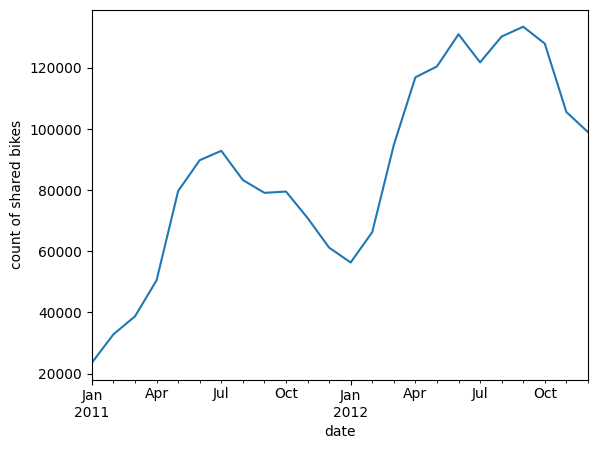

In [15]:
#EDA
df['count'].resample('M').sum().plot() #El resample en una columna indexada permite agrupar por alguna variable de interes, por ejemplo mes

plt.xlabel('date')
plt.ylabel('count of shared bikes')

plt.show()

In [17]:
res = seasonal_decompose(df['count'].values[-250:],period=24) #Descomposicion temporal, descomponer en tendencia, ciclo y residuales
#Tomamos las 255 ultimas horas

res_observed = res.observed
res_trend = res.trend
res_seasonal = res.seasonal
res_residual = res.resid

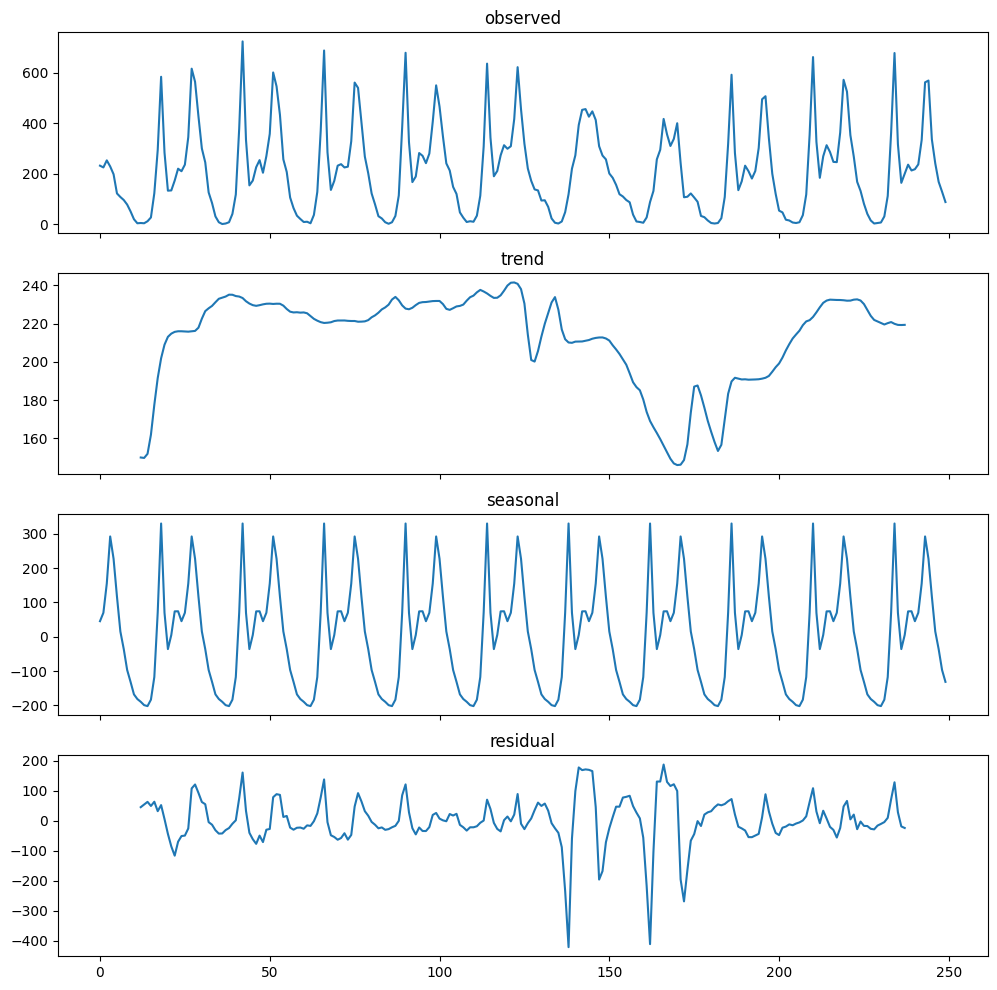

In [19]:
fig, ax = plt.subplots(4, 1, figsize=(12,12), sharex=True)

ax[0].set_title('observed')
ax[0].plot(res_observed)

ax[1].set_title('trend')
ax[1].plot(res_trend)

ax[2].set_title('seasonal')
ax[2].plot(res_seasonal)

ax[3].set_title('residual')
ax[3].plot(res_residual)

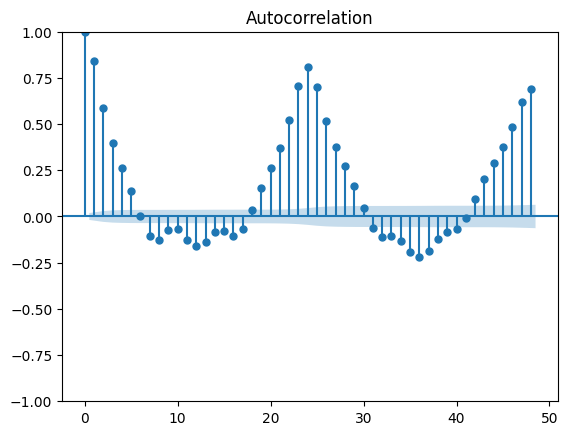

In [20]:
#Seasonal captural la temporalidad.
#Residual: Hay mas residuales los sabados y domingos. Residual es la diferencia entre el seasonal y el observed

plot_acf(df['count'].values, lags=48) 

plt.show()

In [21]:
X = df.drop(['count'], axis=1)
y = df['count']
horizon = 24*7

X_train, X_test, = X.iloc[:-horizon, :], X.iloc[-horizon:,:]
y_train, y_test = y.iloc[:-horizon], y.iloc[-horizon:]

In [23]:
my_array = np.array([1,2,3,4,5,6,7,8,9])

In [27]:
my_array[-2:]

array([8, 9])

In [28]:
my_array[:-2]

array([1, 2, 3, 4, 5, 6, 7])

In [35]:
cat_cols = X_train.select_dtypes(include='category').columns
num_cols = X_train.select_dtypes(include='number').columns
cat_transformer = Pipeline(steps=[('OneHot', OneHotEncoder(drop='if_binary'))])
num_transformer = Pipeline(steps=[('Scaler', MinMaxScaler())])
preprocessor = ColumnTransformer(transformers=[
    ('num', num_transformer, num_cols),
    ('cat', cat_transformer, cat_cols)
])

In [37]:
lgbm = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor',LGBMRegressor(random_state=2029))
])

In [38]:
lgbm.fit(X_train, y_train)

y_hat = lgbm.predict(X_test)

print(f'MAE: {mean_absolute_error(y_test, y_hat)}')
print(f'MSE: {mean_squared_error(y_test, y_hat)}')
print(f'RMSE: {np.sqrt(mean_squared_error(y_test, y_hat))}')

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000141 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 289
[LightGBM] [Info] Number of data points in the train set: 10718, number of used features: 16
[LightGBM] [Info] Start training from score 191.275518
MAE: 54.44878026913637
MSE: 5657.451364023842
RMSE: 75.21603129668463


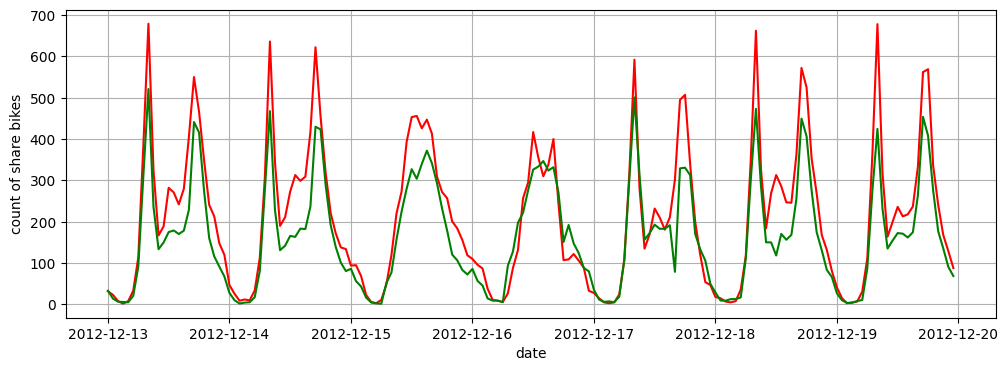

In [39]:
fig = plt.figure(figsize=(12,4))

plt.plot(y_test, color='Red')
plt.plot(pd.Series(y_hat, index=y_test.index), color='green')
plt.xlabel('date')
plt.ylabel('count of share bikes')
plt.grid()
plt.show()